# Classification of bird sound files

<div class="alert alert-warning">
<strong>This notebook assume that the conversion of MP3 files into WAV files has been already done.</strong>

If not, please check the other notebook *birds_sound_visualizations.ipynb*
</div>

From literature, we have found several methods to classify sounds depending on the bird species:

- Logistic Regression
- k Nearest Neighbour (kNN) classifier with histogram-based features
- Support Vector Machines (SVM) with time-summarisation features
- Random Forest

We want a supervised classification, according to the litterature for bird sound SVM and KNN, due to their widespread use and ease of interpretation, will be the best method but it is interesting to compare them to other method thanks to an accuracy value.

The strategy here is to first create a dataframe with all the needed features from the bird sound recording that have been previously converted into wav file. Now that we have our labeled database of previously known bird songs, we use it to create a decision procedure that is used to predict the species of a new bird song.  

### Import libraries

In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [4]:
from data.loader import get_kasios_obs, get_obs, map_path

### Create Dataframes

In [5]:
df_all = get_obs(songs = True)

# Create a new column to tell whether it's a blue pipit or not 
# this is our target for the classification
df_all['Type'] = (df_all['English_name'] == 'Rose-crested Blue Pipit').astype(np.int)


df_all_show = df_all.groupby('Type')
df_all_show = df_all_show.apply(lambda x: x.sample(frac=0.3))
display(df_all_show)

Loading wav files...
Done.


English_name Vocalization_type   Quality    Time  \
Type File ID                                                                   
0    324840             Darkwing Sparrow        call, song         A   10:15   
     76984            Orange Pine Plover              call         C   16:15   
     60256    Green-tipped Scarlet Pipit              song         A     ?:?   
     153963          Vermillion Trillian              call         D   14:35   
     365157                   Queenscoat              call         B   10:00   
     110607                  Scrawny Jay              call         C      10   
     59093             Broad-winged Jojo              Call         B       ?   
     160431               Ordinary Snape              song         C    8:17   
     399993            Lesser Birchbeere        call, song         C    8:30   
     11721             Lesser Birchbeere              call         C    6:00   
     324349                   Queenscoat              song         A    7:30   
     314557          Purple Tooting Tout              call         A    7:00   
     149942            Lesser Birchbeere              call         A   15:56   
     314298                     Bombadil              song         A   12:30   
     74191          Blue-collared Zipper              song         B   15:20   
     131068           Orange Pine Plover              song         B   11:00   
     296527                  Scrawny Jay              call         A    8:00   
     306883      Carries Champagne Pipit              call         A   10:30   
     100555           Eastern Corn Skeet              song         B  7:30am   
     101450                     Bombadil              song         B   11:10   
     336047                   Queenscoat              call         B   13:30   
     380344      Carries Champagne Pipit              call         B   11:00   
     215507                          Qax              song         A    7:17   
     302918                    Pinkfinch              call         A   10:05   
     391655           Orange Pine Plover              call         B    9:30   
     385715   Green-tipped Scarlet Pipit              song         B    9:30   
     386100            Lesser Birchbeere              call  no score   13:13   
     5130             Eastern Corn Skeet              call         B   17:30   
     376425           Eastern Corn Skeet              song         A   10:30   
     185817                     Bombadil              song         B   21:29   
...                                  ...               ...       ...     ...   
1    293916      Rose-crested Blue Pipit              call         A    9:01   
     191418      Rose-crested Blue Pipit              song         B    9:00   
     174364      Rose-crested Blue Pipit              song         D   12:00   
     387404      Rose-crested Blue Pipit              call         A   10:00   
     378584      Rose-crested Blue Pipit              song         B   15:00   
     345559      Rose-crested Blue Pipit              call         B   11:40   
     139528      Rose-crested Blue Pipit              song         A    8:00   
     91351       Rose-crested Blue Pipit              song         B  5:30pm   
     306340      Rose-crested Blue Pipit              song         E   13:00   
     56867       Rose-crested Blue Pipit              Song         C    13.3   
     200110      Rose-crested Blue Pipit              call         B    9:28   
     162569      Rose-crested Blue Pipit              call         A    6:00   
     293913      Rose-crested Blue Pipit              call         B    7:00   
     345802      Rose-crested Blue Pipit              song         B    8:04   
     306343      Rose-crested Blue Pipit              call         B   19:00   
     291091      Rose-crested Blue Pipit              call         B   13:50   
     342729      Rose-crested Blue Pipit              call         B   10:35   
     68258       Rose-creste

In [7]:
# Read all sounds files
sounds_all = []
for i, (index, obs) in enumerate(df_all_show.iterrows()):
    # read wav file
    rate, data = wavfile.read(obs["song"])
    sounds_all.append(data[:500000])

In [12]:
# Read the tests sounds of Kasios
df_test = get_kasios_obs(songs = True)

sounds_test = []
for i, (index, obs) in enumerate(df_test.iterrows()):
    rate, data = wavfile.read(obs["song"])
    sounds_test.append(data[:500000])

Loading wav files...
Done.


In [11]:
# Compute 4 parameters for all sounds
mean_all = []
std_all = []
min_all = []
max_all = []

for sound in sounds_all:
    mean_all.append(np.mean(sound))
    std_all.append(np.std(sound))
    min_all.append(np.min(sound))
    max_all.append(np.max(sound))

df_all_show = df_all_show.assign(mean=mean_all, std=std_all, 
                                 min=min_all, max=max_all)

df_all_show.head()

English_name Vocalization_type Quality   Time  \
Type File ID                                                                
0    324840             Darkwing Sparrow        call, song       A  10:15   
     76984            Orange Pine Plover              call       C  16:15   
     60256    Green-tipped Scarlet Pipit              song       A    ?:?   
     153963          Vermillion Trillian              call       D  14:35   
     365157                   Queenscoat              call       B  10:00   

                   Date    X    Y    color          T  \
Type File ID                                            
0    324840   6/25/2016   82  135  #d62728 2016-06-25   
     76984    4/22/2011  119   73  #8c564b 2011-04-22   
     60256     2/9/1989  153  141  #9467bd 1989-02-09   
     153963   11/5/2013  148  158  #17becf 2013-11-05   
     365157   4/12/2017   46   97  #c7c7c7 2017-04-12   

                                                           song  Type  \
Type File ID                                                            
0    324840   /home/nicolas/Desktop/vast-challenge-2018-mc1/...     0   
     76984    /home/nicolas/Desktop/vast-challenge-2018-mc1/...     0   
     60256    /home/nicolas/Desktop/vast-challenge-2018-mc1/...     0   
     153963   /home/nicolas/Desktop/vast-challenge-2018-mc1/...     0   
     365157   /home/nicolas/Desktop/vast-challenge-2018-mc1/...     0   

                  mean          std    min    max  
Type File ID                                       
0    324840  -0.278036  1141.284125 -15768  15952  
     76984   -0.163630  1917.153640 -27121  24736  
     60256   -0.029478  2737.615196 -27197  26894  
     153963  -0.326230   642.591719  -3369   3859  
     365157  -0.964431   822.808337 -17114  16253

In [14]:
# Compute 4 parameters for test sounds
mean_test = []
std_test = []
min_test = []
max_test = []

for sound in sounds_test:
    mean_test.append(np.mean(sound))
    std_test.append(np.std(sound))
    min_test.append(np.min(sound))
    max_test.append(np.max(sound))

df_test = df_test.assign(mean=mean_test, std=std_test, 
                         min=min_test, max=max_test)

df_test.head()

,X,Y,song,mean,std,min,max
ID,,,,,,,
1,140,119,/home/nicolas/Desktop/vast-challenge-2018-mc1/...,-0.524770,535.062343,-5181,4709
2,63,153,/home/nicolas/Desktop/vast-challenge-2018-mc1/...,-2.085266,911.055410,-6526,6506
3,70,136,/home/nicolas/Desktop/vast-challenge-2018-mc1/...,-0.331892,347.067326,-3850,3794
4,78,150,/home/nicolas/Desktop/vast-challenge-2018-mc1/...,-0.073872,685.782020,-8716,8549
5,60,90,/home/nicolas/Desktop/vast-challenge-2018-mc1/...,-1.817126,823.384616,-6128,5957


### k Nearest Neighbour (k-NN) classifier

#### 1) Training Model

In [23]:
X_sample = df_all_show.drop(columns=['Quality', 'English_name', 
                                     'Vocalization_type', 'Time', 'Date', 
                                     'Type', 'song', 'T', 'color'])

X = []

y = list(df_all_show["Type"])

for row in X_sample.iterrows():
    index, data = row
    X.append(data.tolist())

In [24]:
# k-NN training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [25]:
# Accuracy of the model
accuracy = clf.score(X_test, y_test)
print("Accuracy of the model: %s" % accuracy)

# Confusion matrix
y_predict= clf.predict(X_test)
print("Confusion matrix: \n%s" % confusion_matrix(y_test, y_predict))

Accuracy of the model: 0.9112903225806451
Confusion matrix: 
[[113   0]
 [ 11   0]]


#### 2) Predicting on Kasios test sounds 

In [31]:
X_kasios = []

for row in df_test.drop(columns=['song']).iterrows():
    index, data = row
    X_kasios.append(data.tolist())

In [32]:
kasios_prediction = clf.predict(X_kasios)
for i in range(len(kasios_prediction)):
    print("Sound test %s - Prediction : %s" % (i+1, kasios_prediction[i]))

Sound test 1 - Prediction : 0
Sound test 2 - Prediction : 0
Sound test 3 - Prediction : 0
Sound test 4 - Prediction : 0
Sound test 5 - Prediction : 0
Sound test 6 - Prediction : 0
Sound test 7 - Prediction : 0
Sound test 8 - Prediction : 0
Sound test 9 - Prediction : 0
Sound test 10 - Prediction : 0
Sound test 11 - Prediction : 0
Sound test 12 - Prediction : 0
Sound test 13 - Prediction : 0
Sound test 14 - Prediction : 0
Sound test 15 - Prediction : 0


<div class='alert alert-info'>
According to our <b>k-NN classifier</b>, only the 12th Kasios test sound <b>seems</b> to be Blue Pipit one.
<div>  

### Support Vector Machine (SVM) classifier

#### 1) Training Model

In [33]:
x_list = np.linspace(2**-5, 2**5, 30)
accuracy_C = []
for x in x_list:
    model = svm.SVC(kernel='linear', C=x)
    model.fit(X_train, y_train)
    accuracy_C.append(model.score(X_test, y_test))
x = 0

# select the C with max accuracy
max_index = accuracy_C.index(max(accuracy_C))
C_chosed = x_list[max_index]

KeyboardInterrupt: 

In [ ]:
plt.plot(x_list, accuracy_C, 'ro')
plt.show()

In [15]:
# we do the same thing for gamma

accuracy_gamma = []
for x in x_list:
    model = svm.SVC(kernel='linear', C=C_chosed, gamma=x)
    model.fit(X_train, y_train)
    accuracy_gamma.append(model.score(X_test, y_test))

# to find the C with the max accuracy
max_index = accuracy_gamma.index(max(accuracy_gamma))
gamma_chosed = x_list[max_index]  # the C that we will choose

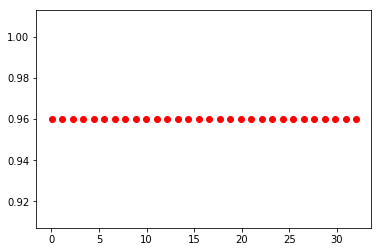

In [16]:
plt.plot(x_list, accuracy_gamma, 'ro')
plt.show()

In [18]:
# We can now define our SVM model
model = svm.SVC(kernel='linear', C=C_chosed, gamma=gamma_chosed)
model.fit(X_train, y_train)

SVC(C=0.03125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.03125, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
# Accuracy of the model
accuracy = model.score(X_test, y_test)
print("Accuracy of the model: %s" % accuracy)

# Confusion matrix
y_predict = model.predict(X_test)
print("Confusion matrix: \n%s" % confusion_matrix(y_test, y_predict))

Accuracy of the model: 0.96
Confusion matrix: 
[[118   1]
 [  4   2]]


#### 2) Predicting on Kasios test sounds 

In [22]:
kasios_prediction = model.predict(X_kasios)
for i in range(len(kasios_prediction)):
    print("Sound test %s - Prediction : %s" % (i+1, kasios_prediction[i]))

Sound test 1 - Prediction : 0
Sound test 2 - Prediction : 0
Sound test 3 - Prediction : 0
Sound test 4 - Prediction : 0
Sound test 5 - Prediction : 0
Sound test 6 - Prediction : 0
Sound test 7 - Prediction : 0
Sound test 8 - Prediction : 0
Sound test 9 - Prediction : 0
Sound test 10 - Prediction : 0
Sound test 11 - Prediction : 1
Sound test 12 - Prediction : 0
Sound test 13 - Prediction : 0
Sound test 14 - Prediction : 0
Sound test 15 - Prediction : 0


<div class='alert alert-info'>
According to our <b>SVM classifier</b>, only the 11th test sound from Kasios <b>seems</b> to be a Rose crested Blue Pipit.
<div>  